<a href="https://colab.research.google.com/github/aaronmj7/MSc_project/blob/main/Project_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project

In [ ]:
pip install gensim

In [ ]:
pip install shap

In [2]:
# Import neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from sklearn.preprocessing import KBinsDiscretizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from keras.layers import Attention, GlobalAveragePooling1D, Reshape
from keras.layers import Dropout, Multiply, RepeatVector
from tensorflow.keras.regularizers import l2
from keras.utils import set_random_seed, plot_model
from keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error


In [3]:
# Set plot theme
sns.set_theme(context='notebook', palette='husl', rc={'patch.edgecolor': 'k'})

# Set random seed
set_random_seed(73)

## Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load movies.csv
movies_df = pd.read_csv('/content/drive/MyDrive/ml-32m/movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# Load tags.csv
tags_df = pd.read_csv('/content/drive/MyDrive/ml-32m/tags.csv')
tags_df.head()

,userId,movieId,tag,timestamp
0,22,26479,Kevin Kline,1583038886
1,22,79592,misogyny,1581476297
2,22,247150,acrophobia,1622483469
3,34,2174,music,1249808064
4,34,2174,weird,1249808102


In [7]:
# Load ratings.csv
ratings_df = pd.read_csv('/content/drive/MyDrive/ml-32m/ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [8]:
# Load links.csv
links_df = pd.read_csv('/content/drive/MyDrive/ml-32m/links.csv')
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


## EDA

In [ ]:
# Display more info

print(movies_df.info(), '\n')
print(tags_df.info(), '\n')
print(ratings_df.info())

In [ ]:
# Check null values
print('Null values\n\n', 'movies_df:')
print(movies_df.isnull().sum())
print('\ntags_df:')
print(tags_df.isnull().sum())
print('\nratings_df:')
print(ratings_df.isnull().sum())

In [ ]:
# Get rows with null values
tags_df[tags_df['tag'].isnull()]

In [ ]:
# Drop null values
tags_df.dropna(inplace=True)
tags_df.head()

In [ ]:
# Check for duplicates
print("Duplicates in movies_df:", movies_df.duplicated().sum())
print("Duplicates in tags_df:", tags_df.duplicated().sum())
print("Duplicates in ratings_df:", ratings_df.duplicated().sum())

### movies_df

In [ ]:
# Describe statistical info
movies_df.describe()

In [ ]:
# Get value count of diferent genres
genre_count = movies_df['genres'].value_counts()
genre_count

In [ ]:
# Get all genres
all_genres = []
for genres in movies_df['genres']:
  all_genres.extend(genres.split('|'))

all_genres = pd.Series(all_genres)
genre_count = all_genres.value_counts()
genre_count

In [ ]:
genre_count.plot(kind='barh')
plt.title('Genre Count')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.show()

In [ ]:
# Wordcloud
genre_text = ' '.join(all_genres)
wordcloud_genre = WordCloud(width=800, height=400, background_color='white').generate(genre_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_genre, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Genres')
plt.show()

### tags_df

In [ ]:
# Describe statistical info
tags_df.describe()

In [ ]:
# Get value count of diferent tags
tags_count = tags_df['tag'].value_counts()
tags_count

In [ ]:
# plot tag counts
plt.figure(figsize=(10, 6))
tags_count[:20].plot(kind='barh')
plt.title('Tag Count')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.show()

In [ ]:
# Generate word cloud
all_tags = " ".join(tag for tag in tags_df['tag'].astype(str))
wordcloud_tags = WordCloud(width=800, height=400, background_color ='white').generate(all_tags)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_tags, interpolation='bilinear')
plt.axis("off")
plt.show()

### ratings_df

In [ ]:
# Describe statistical info
ratings_df.describe()

In [ ]:
# Plot histogram of ratings
plt.hist(ratings_df['rating'])
plt.title('Histogram of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Get value count of diferent ratings
rating_count = ratings_df['rating'].value_counts().sort_index()
rating_count

In [ ]:
ratings_range = np.arange(0.5, 5.5, 0.5)
ratings_range

In [ ]:
# Plot rating boxplot
plt.figure(figsize=(5, 7))
sns.boxplot(y=ratings_df['rating'])
plt.title('Rating Boxplot')
plt.yticks(ratings_range)
plt.ylabel('Rating')
plt.show()

In [ ]:
# Plot rating count
rating_count.plot(kind='bar')
plt.title('Rating Count')
plt.xticks(rotation=0)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [ ]:
# Plot pie chart of rating count
rating_count.plot(kind='pie', autopct='%1.1f%%', fontsize=10, )
plt.title('Rating Count')
plt.ylabel('')
plt.show()

In [ ]:
# Correlation matrix
corr = ratings_df.corr()

# Generate a mask
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".3f", mask=mask)
plt.grid('off')
plt.title('Correlation Matrix')
plt.show()

Only movieId and timestamp have correlation. This might be due to Id increasing with new movies

### All dfs

average rating of each genre, tag-genre correlation,

## Data Pre-processing

### Average ratings

In [9]:
# Calculate the average rating for each movie
average_ratings_df = ratings_df.groupby('movieId')['rating'].mean().reset_index()

# Set movieId as index
average_ratings_df.set_index('movieId', inplace=True)

# Display average ratings
average_ratings_df.head()

,rating
movieId,
1,3.897438
2,3.275758
3,3.139447
4,2.845331
5,3.059602


In [10]:
average_ratings_df.describe()

,rating
count,84432.000000
mean,3.005082
std,0.801820
min,0.500000
25%,2.543478
50%,3.071429
75%,3.500000
max,5.000000


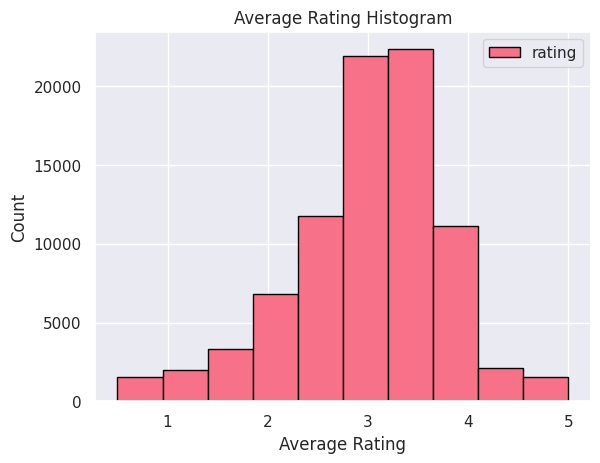

In [11]:
# Plot
average_ratings_df.plot(kind='hist', bins=10)
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.title('Average Rating Histogram')
plt.show()

In [12]:
# Round the average ratings to the nearest 0.5
average_ratings_df['rating'] = (average_ratings_df['rating'] * 2).round() / 2

average_ratings_df.head()

,rating
movieId,
1,4.0
2,3.5
3,3.0
4,3.0
5,3.0


In [13]:
average_ratings_df.describe()

,rating
count,84432.000000
mean,3.004968
std,0.811505
min,0.500000
25%,2.500000
50%,3.000000
75%,3.500000
max,5.000000


NameError: name 'ratings_range' is not defined

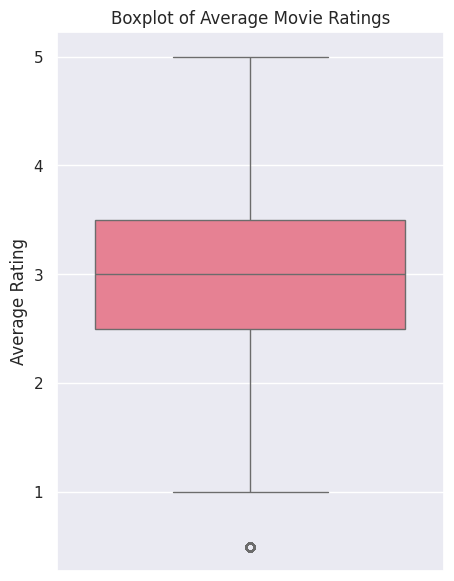

In [14]:
# Plot the boxplot
plt.figure(figsize=(5, 7))
sns.boxplot(y=average_ratings_df['rating'])
plt.title('Boxplot of Average Movie Ratings')
plt.ylabel('Average Rating')
plt.yticks(ratings_range)
plt.show()

In [15]:
average_rating_count = average_ratings_df['rating'].value_counts().sort_index()
average_rating_count

,count
rating,
0.5,1324
1.0,1912
1.5,2474
2.0,7607
2.5,12050
3.0,25611
3.5,21349
4.0,9390
4.5,1196


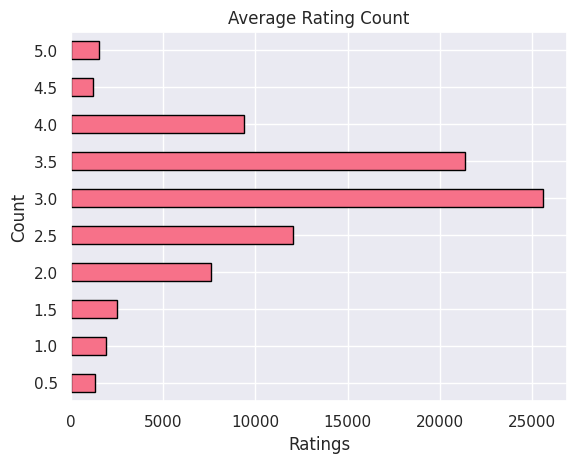

In [16]:
average_rating_count.plot(kind='barh', edgecolor='k')
plt.title('Average Rating Count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

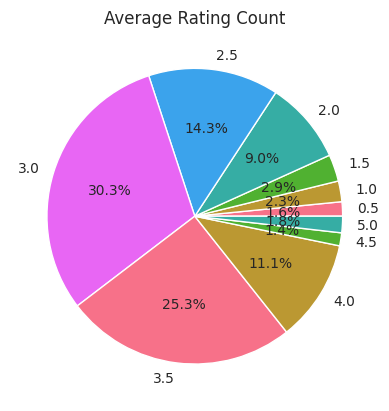

In [17]:
# Pie chart of average ratings
average_rating_count.plot(kind='pie', autopct='%1.1f%%', fontsize=10, wedgeprops={'edgecolor': 'white'})
plt.title('Average Rating Count')
plt.ylabel('')
plt.show()

In [18]:
# Calculate percentages
pd.crosstab(index=average_ratings_df['rating'], columns='percentage', normalize=True) * 100

col_0,percentage
rating,
0.5,1.568126
1.0,2.264544
1.5,2.930169
2.0,9.009617
2.5,14.271840
3.0,30.333286
3.5,25.285437
4.0,11.121376
4.5,1.416525


### Tags per movies

In [19]:
movie_tag_counts = tags_df.groupby('movieId').size().reset_index(name='tag_count')

movie_tag_counts.set_index('movieId', inplace=True)

movie_tag_counts

,tag_count
movieId,
1,1230
2,573
3,23
4,12
5,64
...,...
292143,12
292349,1
292371,1


In [20]:
movie_tag_counts.describe()

,tag_count
count,51323.000000
mean,38.970286
std,160.935483
min,1.000000
25%,2.000000
50%,5.000000
75%,16.000000
max,6697.000000


In [21]:
movie_tag_counts['tag_count'].median()

5.0

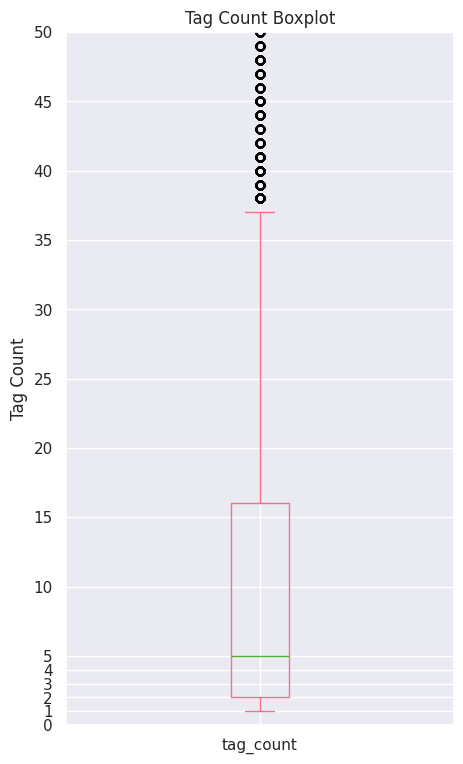

In [22]:
plt.figure(figsize=(5, 9))
movie_tag_counts['tag_count'].plot(kind='box')
plt.title('Tag Count Boxplot')
plt.ylabel('Tag Count')
plt.ylim(0, 50)
ticks = np.hstack([np.arange(0, 6), np.arange(10, 51, 5)])
plt.yticks(ticks)
plt.show()

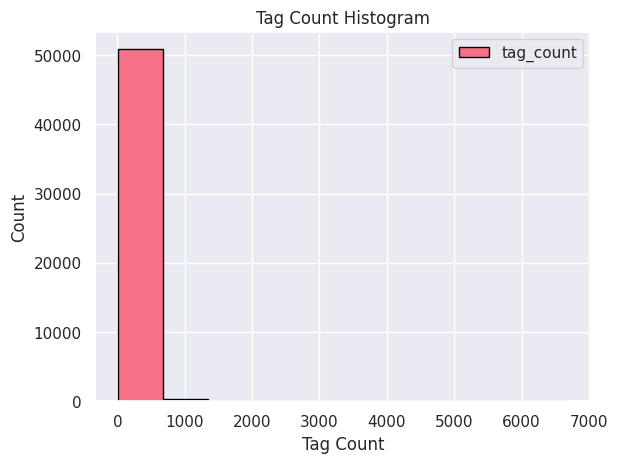

In [23]:
movie_tag_counts.plot(kind='hist', bins=10)
plt.xlabel('Tag Count')
plt.ylabel('Count')
plt.title('Tag Count Histogram')
plt.show()

In [24]:
# Count the occurrences of each tag for each movie
tag_counts_df = tags_df.groupby(['movieId', 'tag']).size().reset_index(name='tag_count')

tag_counts_df

,movieId,tag,tag_count
0,1,1990s,1
1,1,2009 reissue in Stereoscopic 3-D,1
2,1,3 dimensional,1
3,1,3D,3
4,1,3d,1
...,...,...,...
1086820,292349,politically incorrect,1
1086821,292371,Stephen King,1
1086822,292597,artificial intelligence,1
1086823,292629,documentary filmmaking,1


In [25]:
tag_counts_df.sort_values(by=['movieId', 'tag_count'], ascending=[True, False])

,movieId,tag,tag_count
27,1,Pixar,86
50,1,animation,74
19,1,Disney,54
206,1,funny,50
31,1,Tom Hanks,47
...,...,...,...
1086820,292349,politically incorrect,1
1086821,292371,Stephen King,1
1086822,292597,artificial intelligence,1
1086823,292629,documentary filmmaking,1


In [26]:
tag_counts_df['tag_count'].describe()

,tag_count
count,1.086825e+06
mean,1.840273e+00
std,5.233296e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,5.960000e+02


In [27]:
# Take the top n tags for each movie
n = 5
top_tags_df = tag_counts_df.groupby('movieId').head(n)

# Aggregate top tags into a single string for each movie
top_tags_df = top_tags_df.groupby('movieId')['tag'].apply(lambda tags: ','.join(tags)).reset_index()
top_tags_df.columns = ['movieId', 'top_tags']

# Merge the top tags with average_ratings_df
movies_with_ratings_and_tags_df = pd.merge(average_ratings_df, top_tags_df, on='movieId', how='left')

movies_with_ratings_and_tags_df

,movieId,rating,top_tags
0,1,4.0,"1990s,2009 reissue in Stereoscopic 3-D,3 dimen..."
1,2,3.5,"1860s,1960s,1990s,19th century,20th century"
2,3,3.0,"CLV,Funniest Movies,Jack Lemmon,Minnesota,NO_F..."
3,4,3.0,"CLV,based on novel or book,characters,chick fl..."
4,5,3.0,"4th wall,CLV,Comedy,Diane Keaton,Fantasy"
...,...,...,...
84427,292731,4.0,NaN
84428,292737,1.5,NaN
84429,292753,4.0,NaN
84430,292755,1.0,NaN


In [28]:
movies_with_ratings_and_tags_df.dropna(inplace=True)
movies_with_ratings_and_tags_df

,movieId,rating,top_tags
0,1,4.0,"1990s,2009 reissue in Stereoscopic 3-D,3 dimen..."
1,2,3.5,"1860s,1960s,1990s,19th century,20th century"
2,3,3.0,"CLV,Funniest Movies,Jack Lemmon,Minnesota,NO_F..."
3,4,3.0,"CLV,based on novel or book,characters,chick fl..."
4,5,3.0,"4th wall,CLV,Comedy,Diane Keaton,Fantasy"
...,...,...,...
84360,292057,2.0,illegal immigration
84368,292143,2.5,"Cadaqués,China,Spain,Xiamen,catalonia"
84379,292349,3.0,politically incorrect
84389,292371,2.5,Stephen King


In [29]:
# Split the genres by the ',' separator and flatten the list to get unique genres
unique_tags = pd.Series(movies_with_ratings_and_tags_df['top_tags'].str.split(',').explode().unique())

print(unique_tags)

0                                   1990s
1        2009 reissue in Stereoscopic 3-D
2                           3 dimensional
3                                      3D
4                                      3d
                       ...               
36279                    Northern England
36280                           excercise
36281                           dog death
36282          full frontal female nudity
36283                              Xiamen
Length: 36284, dtype: object


### Getting genres

In [30]:
# Replace '|' with ',' in the 'genre' column
movies_df['genres'] = movies_df['genres'].str.replace('|', ',')
movies_df

,movieId,title,genres
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy"
1,2,Jumanji (1995),"Adventure,Children,Fantasy"
2,3,Grumpier Old Men (1995),"Comedy,Romance"
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance"
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),"Comedy,Drama"
87582,292753,Orca (2023),Drama
87583,292755,The Angry Breed (1968),Drama


In [31]:
movies_df = movies_df[movies_df['genres'] != '(no genres listed)']
movies_df

,movieId,title,genres
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy"
1,2,Jumanji (1995),"Adventure,Children,Fantasy"
2,3,Grumpier Old Men (1995),"Comedy,Romance"
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance"
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),"Comedy,Drama"
87582,292753,Orca (2023),Drama
87583,292755,The Angry Breed (1968),Drama


In [32]:
# Calculate the number of genres for each movie, using .loc to avoid SettingWithCopyWarning
movies_df.loc[:, 'genre_count'] = movies_df['genres'].str.split(',').str.len()
movies_df

<ipython-input-32-ca731598cdbf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df.loc[:, 'genre_count'] = movies_df['genres'].str.split(',').str.len()


,movieId,title,genres,genre_count
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",5
1,2,Jumanji (1995),"Adventure,Children,Fantasy",3
2,3,Grumpier Old Men (1995),"Comedy,Romance",2
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance",3
4,5,Father of the Bride Part II (1995),Comedy,1
...,...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama,1
87581,292737,Shelter in Solitude (2023),"Comedy,Drama",2
87582,292753,Orca (2023),Drama,1
87583,292755,The Angry Breed (1968),Drama,1


In [33]:
movies_df['genre_count'].describe()

,genre_count
count,80505.000000
mean,1.827091
std,0.955556
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,10.000000


In [34]:
movies_df[movies_df['genre_count'] > 5]['genres']

,genres
196,"Action,Crime,Drama,Mystery,Sci-Fi,Thriller"
359,"Adventure,Animation,Children,Drama,Musical,IMAX"
454,"Action,Adventure,Crime,Drama,Romance,Thriller"
540,"Action,Adventure,Children,Comedy,Fantasy,Sci-Fi"
587,"Animation,Children,Fantasy,Musical,Romance,IMAX"
...,...
84413,"Adventure,Animation,Children,Comedy,Fantasy,Ro..."
85543,"Adventure,Animation,Children,Comedy,Fantasy,Ro..."
85621,"Action,Adventure,Drama,Fantasy,Mystery,Romance..."
86395,"Action,Adventure,Drama,Horror,Mystery,Thriller"


In [35]:
movies_df = movies_df[movies_df['genre_count'] <= 5]
movies_df

,movieId,title,genres,genre_count
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",5
1,2,Jumanji (1995),"Adventure,Children,Fantasy",3
2,3,Grumpier Old Men (1995),"Comedy,Romance",2
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance",3
4,5,Father of the Bride Part II (1995),Comedy,1
...,...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama,1
87581,292737,Shelter in Solitude (2023),"Comedy,Drama",2
87582,292753,Orca (2023),Drama,1
87583,292755,The Angry Breed (1968),Drama,1


### Final df

In [36]:
# Merge movies_with_ratings_and_tags_df with genres from movies_df
final_df = pd.merge(movies_with_ratings_and_tags_df, movies_df[['movieId', 'genres']], on='movieId', how='left')
final_df

,movieId,rating,top_tags,genres
0,1,4.0,"1990s,2009 reissue in Stereoscopic 3-D,3 dimen...","Adventure,Animation,Children,Comedy,Fantasy"
1,2,3.5,"1860s,1960s,1990s,19th century,20th century","Adventure,Children,Fantasy"
2,3,3.0,"CLV,Funniest Movies,Jack Lemmon,Minnesota,NO_F...","Comedy,Romance"
3,4,3.0,"CLV,based on novel or book,characters,chick fl...","Comedy,Drama,Romance"
4,5,3.0,"4th wall,CLV,Comedy,Diane Keaton,Fantasy",Comedy
...,...,...,...,...
48165,292057,2.0,illegal immigration,Drama
48166,292143,2.5,"Cadaqués,China,Spain,Xiamen,catalonia",NaN
48167,292349,3.0,politically incorrect,"Comedy,Horror"
48168,292371,2.5,Stephen King,"Fantasy,Horror"


In [37]:
final_df.dropna(inplace=True)
final_df

,movieId,rating,top_tags,genres
0,1,4.0,"1990s,2009 reissue in Stereoscopic 3-D,3 dimen...","Adventure,Animation,Children,Comedy,Fantasy"
1,2,3.5,"1860s,1960s,1990s,19th century,20th century","Adventure,Children,Fantasy"
2,3,3.0,"CLV,Funniest Movies,Jack Lemmon,Minnesota,NO_F...","Comedy,Romance"
3,4,3.0,"CLV,based on novel or book,characters,chick fl...","Comedy,Drama,Romance"
4,5,3.0,"4th wall,CLV,Comedy,Diane Keaton,Fantasy",Comedy
...,...,...,...,...
48164,292033,3.0,neighbor,"Comedy,Drama"
48165,292057,2.0,illegal immigration,Drama
48167,292349,3.0,politically incorrect,"Comedy,Horror"
48168,292371,2.5,Stephen King,"Fantasy,Horror"


In [38]:
# Split the genres by the ',' separator and flatten the list to get unique genres
unique_genres = pd.Series(final_df['genres'].str.split(',').explode().unique())

print(unique_genres)

0       Adventure
1       Animation
2        Children
3          Comedy
4         Fantasy
5         Romance
6           Drama
7          Action
8           Crime
9        Thriller
10         Horror
11        Mystery
12         Sci-Fi
13           IMAX
14    Documentary
15            War
16        Musical
17        Western
18      Film-Noir
dtype: object


In [39]:
final_df.sort_values(by='movieId', inplace=True)
final_df.reset_index(drop=True, inplace=True)
final_df

,movieId,rating,top_tags,genres
0,1,4.0,"1990s,2009 reissue in Stereoscopic 3-D,3 dimen...","Adventure,Animation,Children,Comedy,Fantasy"
1,2,3.5,"1860s,1960s,1990s,19th century,20th century","Adventure,Children,Fantasy"
2,3,3.0,"CLV,Funniest Movies,Jack Lemmon,Minnesota,NO_F...","Comedy,Romance"
3,4,3.0,"CLV,based on novel or book,characters,chick fl...","Comedy,Drama,Romance"
4,5,3.0,"4th wall,CLV,Comedy,Diane Keaton,Fantasy",Comedy
...,...,...,...,...
45886,292033,3.0,neighbor,"Comedy,Drama"
45887,292057,2.0,illegal immigration,Drama
45888,292349,3.0,politically incorrect,"Comedy,Horror"
45889,292371,2.5,Stephen King,"Fantasy,Horror"


In [40]:
final_df['rating'].describe()

,rating
count,45891.000000
mean,3.074317
std,0.661412
min,0.500000
25%,3.000000
50%,3.000000
75%,3.500000
max,5.000000


In [41]:
final_df['rating'].value_counts().sort_index()

,count
rating,
0.5,266
1.0,456
1.5,860
2.0,3166
2.5,6705
3.0,15035
3.5,14073
4.0,4757
4.5,287


### time trend

In [ ]:
# Convert timestamps to datetime
tags_df['datetime'] = pd.to_datetime(tags_df['timestamp'], unit='s')
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

# Add year column to both dataframes
tags_df['year'] = tags_df['datetime'].dt.year
ratings_df['year'] = ratings_df['datetime'].dt.year


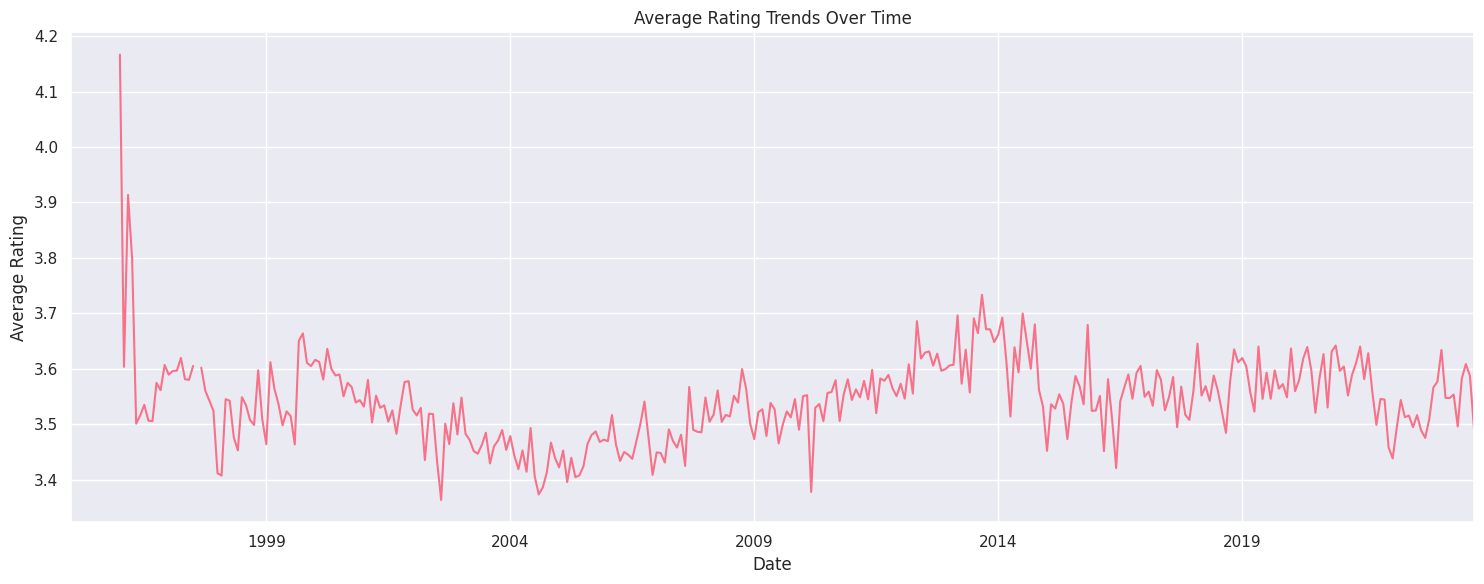

In [ ]:
# Average Rating Trends
monthly_ratings = ratings_df.set_index('datetime').resample('ME')['rating'].mean()
plt.figure(figsize=(15, 6))
monthly_ratings.plot()
plt.title('Average Rating Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()

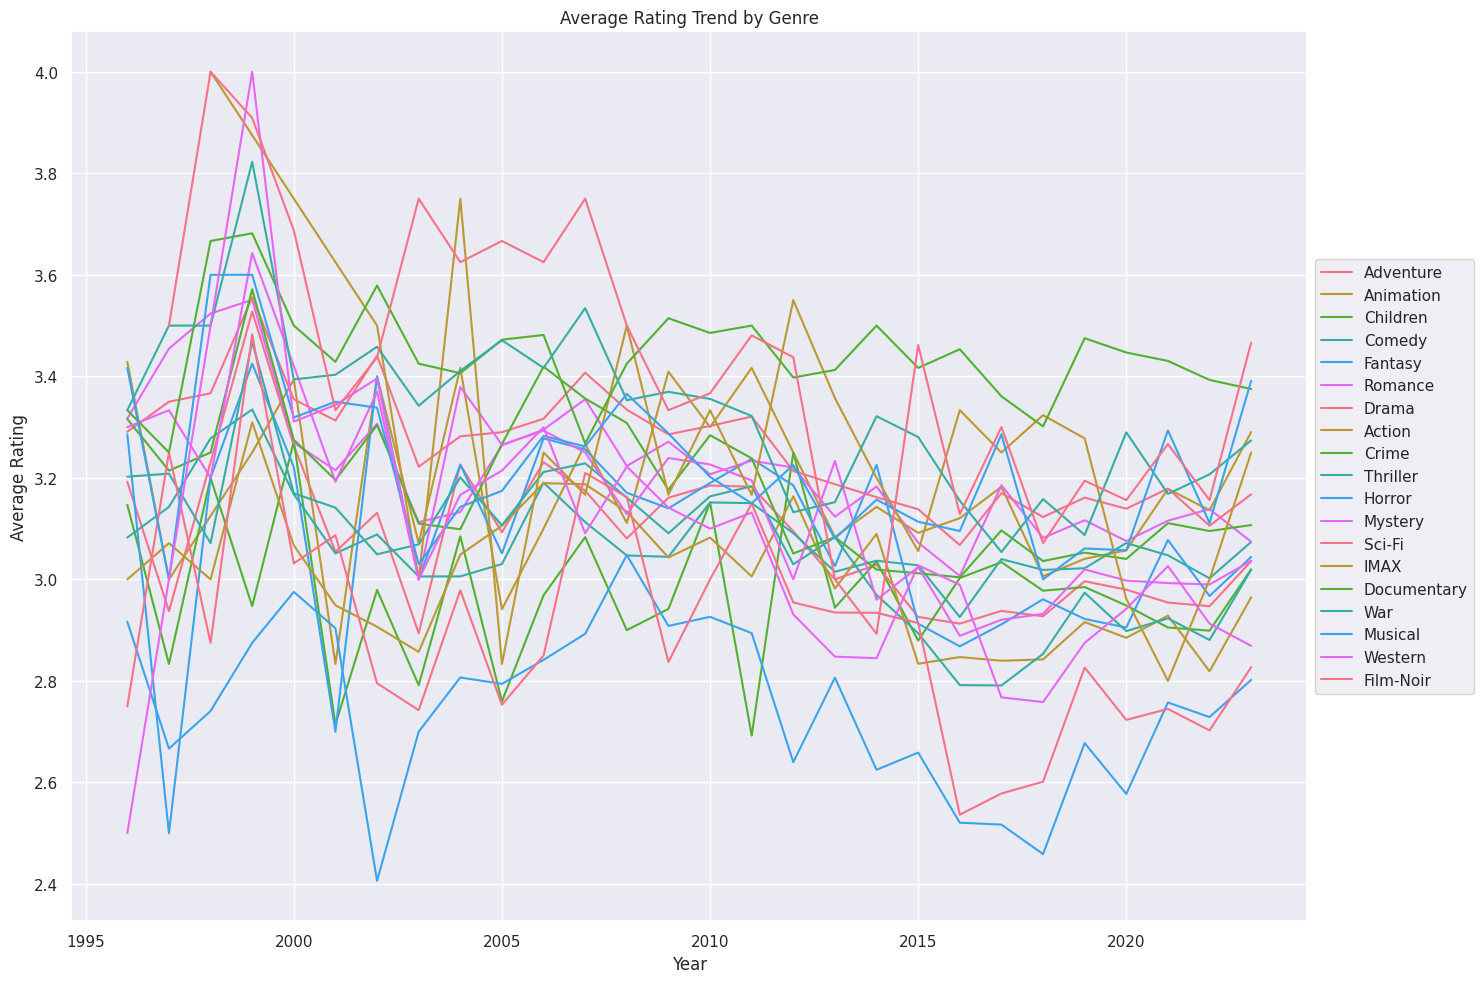

In [ ]:
# Average rating trend of each genre
def calculate_genre_trends(df):
    genre_trends = {}
    for index, row in df.iterrows():
        # Access genres
        genres = row['genres']

        for genre in genres:
            genre = genre.strip() if isinstance(genre, str) else genre  # Strip if string, handle non-strings
            if genre not in genre_trends:
                genre_trends[genre] = []

            rating = row['rating']
            year = ratings_df[ratings_df['movieId'] == row['movieId']]['year'].values
            if len(year) > 0:
                genre_trends[genre].append({'rating': rating, 'year': year[0]})

    genre_avg_trends = {}
    for genre, data in genre_trends.items():
        genre_df = pd.DataFrame(data)
        genre_avg_trends[genre] = genre_df.groupby('year')['rating'].mean()

    return genre_avg_trends

genre_avg_trends = calculate_genre_trends(final_df)

# Plotting the trends
plt.figure(figsize=(15, 10))
for genre, trend in genre_avg_trends.items():
    plt.plot(trend.index, trend.values, label=genre)

plt.title('Average Rating Trend by Genre')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
import re
# Analyze tag-genre correlations
unique_tags = pd.Series(final_df['top_tags'].str.split(',').explode().unique())
unique_genres = pd.Series(final_df['genres'].str.split(',').explode().unique())

def calculate_genre_tag_correlation(final_df, unique_tags, unique_genres):
    correlations = []
    for genre in unique_genres:
        genre_movies = final_df[final_df['genres'].str.contains(genre)]
        total_genre_movies = len(genre_movies)
        for tag in unique_tags:
            escaped_tag = re.escape(tag)
            movies_with_both = genre_movies[genre_movies['top_tags'].str.contains(escaped_tag)]
            count_both = len(movies_with_both)
            correlations.append({'genre': genre, 'tag': tag, 'correlation': count_both / total_genre_movies if total_genre_movies > 0 else 0})
    return pd.DataFrame(correlations)

# Calculate and sort correlations
genre_tag_correlation_df = calculate_genre_tag_correlation(final_df, unique_tags, unique_genres)
genre_tag_correlation_df.sort_values(by='correlation', ascending=False).head(10)

,genre,tag,correlation
145770,Fantasy,,1.0
39555,Animation,,1.0
499820,Documentary,,1.0
606035,Western,,1.0
464415,IMAX,,1.0
251985,Action,,1.0
429010,Sci-Fi,,1.0
4150,Adventure,,1.0
110365,Comedy,,1.0
641440,Film-Noir,,1.0


tag name?

### Strings to vectors

In [ ]:
'''# Initialise tokenizers
tokenizer_tags = Tokenizer(filters='', lower=True)
tokenizer_genres = Tokenizer(filters='', lower=True)

# Function to clean and split comma-separated items
def clean_and_split(x):
    if isinstance(x, list):
        # Join list items and split by comma
        return [item.strip() for item in ','.join(x).split(',')]
    elif isinstance(x, str):
        # Split string by comma
        return [item.strip() for item in x.split(',')]
    return []

# Fit tokenizers on cleaned text
tokenizer_tags.fit_on_texts(final_df['top_tags'].apply(clean_and_split))
tokenizer_genres.fit_on_texts(final_df['genres'].apply(clean_and_split))

# Convert to sequences
tag_sequences = tokenizer_tags.texts_to_sequences(final_df['top_tags'].apply(clean_and_split))
genre_sequences = tokenizer_genres.texts_to_sequences(final_df['genres'].apply(clean_and_split))

# Verify tokenization
print("\nSample of genre vocabulary:")
print({v: k for k, v in tokenizer_genres.word_index.items()})
print("\nSample of tag vocabulary:")
print({v: k for k, v in tokenizer_tags.word_index.items()})'''

'# Initialise tokenizers\ntokenizer_tags = Tokenizer(filters=\'\', lower=True)\ntokenizer_genres = Tokenizer(filters=\'\', lower=True)\n\n# Function to clean and split comma-separated items\ndef clean_and_split(x):\n    if isinstance(x, list):\n        # Join list items and split by comma\n        return [item.strip() for item in \',\'.join(x).split(\',\')]\n    elif isinstance(x, str):\n        # Split string by comma\n        return [item.strip() for item in x.split(\',\')]\n    return []\n\n# Fit tokenizers on cleaned text\ntokenizer_tags.fit_on_texts(final_df[\'top_tags\'].apply(clean_and_split))\ntokenizer_genres.fit_on_texts(final_df[\'genres\'].apply(clean_and_split))\n\n# Convert to sequences\ntag_sequences = tokenizer_tags.texts_to_sequences(final_df[\'top_tags\'].apply(clean_and_split))\ngenre_sequences = tokenizer_genres.texts_to_sequences(final_df[\'genres\'].apply(clean_and_split))\n\n# Verify tokenization\nprint("\nSample of genre vocabulary:")\nprint({v: k for k, v in to

In [ ]:
'''# Find the maximum length of sequences for tags and genres
max_tag_length = max(len(seq) for seq in tag_sequences)
max_genre_length = max(len(seq) for seq in genre_sequences)

# Pad sequences
tag_sequences_padded = pad_sequences(tag_sequences, maxlen=max_tag_length, padding='post')
genre_sequences_padded = pad_sequences(genre_sequences, maxlen=max_genre_length, padding='post')

max_tag_length, max_genre_length'''

"# Find the maximum length of sequences for tags and genres\nmax_tag_length = max(len(seq) for seq in tag_sequences)\nmax_genre_length = max(len(seq) for seq in genre_sequences)\n\n# Pad sequences\ntag_sequences_padded = pad_sequences(tag_sequences, maxlen=max_tag_length, padding='post')\ngenre_sequences_padded = pad_sequences(genre_sequences, maxlen=max_genre_length, padding='post')\n\nmax_tag_length, max_genre_length"

In [ ]:
# Function to clean and split comma-separated items
def clean_and_split(x):
    if isinstance(x, list):
        # Join list items and split by comma
        return [item.strip() for item in ','.join(x).split(',')]
    elif isinstance(x, str):
        # Split string by comma
        return [item.strip() for item in x.split(',')]
    return []


# Prepare data for Word2Vec
tag_words = final_df['top_tags'].apply(clean_and_split).tolist()
genre_words = final_df['genres'].apply(clean_and_split).tolist()

# Combine all words for Word2Vec training
all_words = tag_words + genre_words

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=all_words, vector_size=100, window=5, min_count=1, workers=4, sg=1, seed=73)

# Save vocabulary
tag_vocab = word2vec_model.wv.key_to_index
genre_vocab = word2vec_model.wv.key_to_index

print("\nSample of Word2Vec vocabulary (tags and genres combined):")
print(list(tag_vocab.keys())[:10])


Sample of Word2Vec vocabulary (tags and genres combined):
['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Documentary', 'Crime', 'BD-R', 'Adventure']


In [ ]:
# Function to embed sequences using Word2Vec
def embed_sequence(sequence, model, vector_size=100):
    """
    Embed a sequence of words using Word2Vec model.
    If a word is not in the vocabulary, ignore it.
    """
    embeddings = [model.wv[word] for word in sequence if word in model.wv]
    return embeddings  # Return a list of individual embeddings

# Define maximum length for padding
MAX_TAGS_LENGTH = 5  # Maximum number of tags to consider for each movie
MAX_GENRES_LENGTH = 5  # Maximum number of genres to consider for each movie

# Embed the sequences for tags and genres using the Word2Vec model
tags_embeded = [embed_sequence(clean_and_split(x), word2vec_model) for x in final_df['top_tags']]
genres_embeded = [embed_sequence(clean_and_split(x), word2vec_model) for x in final_df['genres']]


In [ ]:
# Function to apply padding to sequences
def pad_sequence(embeddings, max_len, vector_size=100):
    # Pad with zero vectors if the number of embeddings is less than max_len
    if len(embeddings) < max_len:
        padding = [np.zeros(vector_size)] * (max_len - len(embeddings))
        embeddings.extend(padding)
    # Truncate if the number of embeddings exceeds max_len
    return embeddings[:max_len]


# Apply padding to tags and genres embeddings
tags_padded = np.array([pad_sequence(tags, MAX_TAGS_LENGTH) for tags in tags_embeded])
genres_padded = np.array([pad_sequence(genres, MAX_GENRES_LENGTH) for genres in genres_embeded])

# Check sample tag and genre embeddings along with corresponding names
for i in range(3):
    print(f"\nSample {i+1}:")
    print(f"Tags: {final_df['top_tags'].iloc[i]}")
    print(f"Genre: {final_df['genres'].iloc[i]}")
    print(f"Tag Embeddings (Padded): {tags_padded[i].shape}")
    print(f"Genre Embeddings (Padded): {genres_padded[i].shape}")



Sample 1:
Tags: 1990s,2009 reissue in Stereoscopic 3-D,3 dimensional,3D,3d
Genre: Adventure,Animation,Children,Comedy,Fantasy
Tag Embeddings (Padded): (5, 100)
Genre Embeddings (Padded): (5, 100)

Sample 2:
Tags: 1860s,1960s,1990s,19th century,20th century
Genre: Adventure,Children,Fantasy
Tag Embeddings (Padded): (5, 100)
Genre Embeddings (Padded): (5, 100)

Sample 3:
Tags: CLV,Funniest Movies,Jack Lemmon,Minnesota,NO_FA_GANES
Genre: Comedy,Romance
Tag Embeddings (Padded): (5, 100)
Genre Embeddings (Padded): (5, 100)


In [ ]:
# Check shapes

final_df['movieId'].shape, genres_padded.shape, tags_padded.shape

((45891,), (45891, 5, 100), (45891, 5, 100))

In [ ]:
# prompt: find tag genre correlation

import pandas as pd
import numpy as np
import re
# Assuming 'final_df' is already defined as in your provided code

# Create a list to store genre-tag correlation data
genre_tag_correlations = []

# Iterate through unique genres
for genre in unique_genres:
    # Find movies of this genre
    genre_movies = final_df[final_df['genres'].str.contains(genre)]

    # For each tag, calculate the correlation with the current genre
    for tag in unique_tags:
        # Escape special characters in the tag using re.escape()
        escaped_tag = re.escape(tag)

        # Count the number of movies with both genre and tag
        movies_with_both = genre_movies[genre_movies['top_tags'].str.contains(escaped_tag)]
        count_both = len(movies_with_both)

        # Count the total number of movies of this genre
        total_genre_movies = len(genre_movies)

        # Calculate the correlation (proportion of movies of this genre having the tag)
        correlation = count_both / total_genre_movies if total_genre_movies > 0 else 0  # Avoid division by zero

        # Store the data
        genre_tag_correlations.append([genre, tag, correlation])

# Create a DataFrame from the correlation data
correlation_df = pd.DataFrame(genre_tag_correlations, columns=['Genre', 'Tag', 'Correlation'])

# Display the correlation DataFrame
correlation_df

# Optional: You can further analyze or visualize this data
# For example, to find the strongest correlations for each genre:
strongest_correlations = correlation_df.loc[correlation_df.groupby('Genre')['Correlation'].idxmax()]
print("\nStrongest correlations for each genre:\n", strongest_correlations)


Strongest correlations for each genre:
               Genre Tag  Correlation
258146       Action              1.0
4158      Adventure              1.0
40442     Animation              1.0
76726      Children              1.0
113010       Comedy              1.0
294430        Crime              1.0
512134  Documentary              1.0
221862        Drama              1.0
149294      Fantasy              1.0
657270    Film-Noir              1.0
366998       Horror              1.0
475850         IMAX              1.0
584702      Musical              1.0
403282      Mystery              1.0
185578      Romance              1.0
439566       Sci-Fi              1.0
330714     Thriller              1.0
548418          War              1.0
620986      Western              1.0


### Balance Dataset

In [ ]:
# Prepare inputs and outputs
X_movie_id = final_df.index.values
X_tags = tags_padded
X_genres = genres_padded
y = final_df['rating'].values

# Discretize into bins for oversampling
bins = len(np.unique(y))
binner = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
y_binned = binner.fit_transform(y.reshape(-1, 1)).astype(int).flatten()

# Reshape for compatibility with oversampling
X_movie_id = X_movie_id.reshape(-1, 1)
X_tags_flattened = X_tags.reshape(X_tags.shape[0], -1)
X_genres_flattened = X_genres.reshape(X_genres.shape[0], -1)

# Combine features into a single array for oversampling
X_combined = np.hstack([
    X_movie_id,
    X_tags_flattened,
    X_genres_flattened
])

# Apply Random Oversampling
ros = RandomOverSampler(random_state=73)
X_resampled, y_resampled = ros.fit_resample(X_combined, y_binned)

# Split resampled data back into original inputs
X_movie_id_resampled = X_resampled[:, 0].astype(int)
X_tags_resampled = X_resampled[:, 1:X_tags_flattened.shape[1] + 1]
X_genres_resampled = X_resampled[:, X_tags_flattened.shape[1] + 1:]

# Reshape tags and genres back to original shapes
X_tags_resampled = X_tags_resampled.reshape(-1, *X_tags.shape[1:])
X_genres_resampled = X_genres_resampled.reshape(-1, *X_genres.shape[1:])

# Define the original scale for y values
original_labels = np.linspace(0.5, 5.0, bins)

# Map y_resampled back to original labels
y_rescaled = original_labels[y_resampled]

# Check y values
unique, counts = np.unique(y_rescaled, return_counts=True)

for label, count in zip(unique, counts):
    print(f"Label: {label}, Count: {count}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Label: 0.5, Count: 15035
Label: 1.0, Count: 15035
Label: 1.5, Count: 15035
Label: 2.0, Count: 15035
Label: 2.5, Count: 15035
Label: 3.0, Count: 15035
Label: 3.5, Count: 15035
Label: 4.0, Count: 15035
Label: 4.5, Count: 15035
Label: 5.0, Count: 15035


In [ ]:
# Split to train and validation datasets
X_movie_id_train, X_movie_id_val, X_tags_train, X_tags_val, X_genres_train, X_genres_val, y_train, y_val = train_test_split(
    X_movie_id_resampled,
    X_tags_resampled,
    X_genres_resampled,
    y_rescaled,
    test_size=0.2,
    random_state=73
)

In [ ]:
# Print data shapes to confirm
print("Training data shapes:")
print("Movie IDs:", X_movie_id_train.shape)
print("Tags:", X_tags_train.shape)
print("Genres:", X_genres_train.shape)
print("Ratings:", y_train.shape)

print("\nValidation data shapes:")
print("Movie IDs:", X_movie_id_val.shape)
print("Tags:", X_tags_val.shape)
print("Genres:", X_genres_val.shape)
print("Ratings:", y_val.shape)

Training data shapes:
Movie IDs: (120280,)
Tags: (120280, 5, 100)
Genres: (120280, 5, 100)
Ratings: (120280,)

Validation data shapes:
Movie IDs: (30070,)
Tags: (30070, 5, 100)
Genres: (30070, 5, 100)
Ratings: (30070,)


## Model

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Multiply, GlobalAveragePooling1D, Flatten, RepeatVector, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Parameters
regularization_strength = 1e-2
dropout_unit = 0.1

from tensorflow.keras.layers import Embedding, Reshape

# Define the model inputs
movie_input = Input(shape=(1,), name='movie_input')  # For movie IDs
genre_input = Input(shape=(5, 100), name='genre_input')  # Genres embeddings
tag_input = Input(shape=(5, 100), name='tag_input')  # Tags embeddings

# Embedding Layer for movieId
movie_embedding_layer = Embedding(
    input_dim=len(final_df['movieId'].unique()),
    output_dim=8,
    name='movie_embedding')

# Embed movieId
movie_embeddings = movie_embedding_layer(movie_input)
movie_embeddings = Flatten()(movie_embeddings)  # Flatten for interaction

# Repeat movie embedding to match the dimensions of genres and tags
movie_embedding_repeated_genres = RepeatVector(5)(movie_embeddings)  # Repeat for 5 genres
movie_embedding_repeated_tags = RepeatVector(5)(movie_embeddings)    # Repeat for 5 tags

# Concatenate for interaction
movie_genre_embeddings = Concatenate(axis=-1)([genre_input, movie_embedding_repeated_genres])
movie_tag_embeddings = Concatenate(axis=-1)([tag_input, movie_embedding_repeated_tags])


# Deep Component
# Attention Layer
genre_attention = Attention(name="genre_attention")([movie_genre_embeddings, movie_genre_embeddings])
tag_attention = Attention(name="tag_attention")([movie_tag_embeddings, movie_tag_embeddings])

# Global Average Pooling after attention
deep_interaction_layer = Concatenate()([
    GlobalAveragePooling1D()(genre_attention),
    GlobalAveragePooling1D()(tag_attention)
])

# Dense layers with L2 regularization and dropout
deep_dense_layer = Dense(128, activation='relu', kernel_regularizer=l2(regularization_strength), name='deep_dense_layer_1')(deep_interaction_layer)
deep_dense_layer = Dropout(dropout_unit)(deep_dense_layer)
deep_dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(regularization_strength), name='deep_dense_layer_2')(deep_dense_layer)
deep_dense_layer = Dropout(dropout_unit)(deep_dense_layer)


# Wide Component
# Global Average Pooling
genre_pooled_wide = GlobalAveragePooling1D()(movie_genre_embeddings)
tag_pooled_wide = GlobalAveragePooling1D()(movie_tag_embeddings)

# Element-wise product for wide interaction
wide_interaction_layer = Multiply()([genre_pooled_wide, tag_pooled_wide])

# Combine Deep and Wide Components
combined_layer = Concatenate()([deep_dense_layer, wide_interaction_layer])

# Final Dense Layer
final_dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(regularization_strength), name='final_dense_layer_1')(combined_layer)
final_dense_layer = Dropout(dropout_unit)(final_dense_layer)


# Output Layer for regression
output = Dense(1, activation='linear', dtype='float32', name='output_layer')(final_dense_layer)

# Define model
model = Model(inputs=[movie_input, genre_input, tag_input], outputs=output, name='Model')

model.summary()


Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ movie_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_embedding           │ (None, 1, 8)           │        367,128 │ movie_input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_14 (Flatten)      │ (None, 8)              │              0 │ movie_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ genre_input (InputLayer)  │ (None, 5, 100)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_28          │ (None, 5, 8)           │              0 │ flatten_14[0][0]       │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tag_input (InputLayer)    │ (None, 5, 100)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_29          │ (None, 5, 8)           │              0 │ flatten_14[0][0]       │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_56            │ (None, 5, 108)         │              0 │ genre_input[0][0],     │
│ (Concatenate)             │                        │                │ repeat_vector_28[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_57            │ (None, 5, 108)         │              0 │ tag_input[0][0],       │
│ (Concatenate)             │                        │                │ repeat_vector_29[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ genre_attention           │ (None, 5, 108)         │              0 │ concatenate_56[0][0],  │
│ (Attention)               │                        │                │ concatenate_56[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tag_attention (Attention) │ (None, 5, 108)         │              0 │ concatenate_57[0][0],  │
│                           │                        │                │ concatenate_57[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 108)            │              0 │ genre_attention[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 108)            │              0 │ tag_attention[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_58            │ (None, 216)            │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ deep_dense_layer_1   

 Total params: 408,729 (1.56 MB)

 Trainable params: 408,729 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

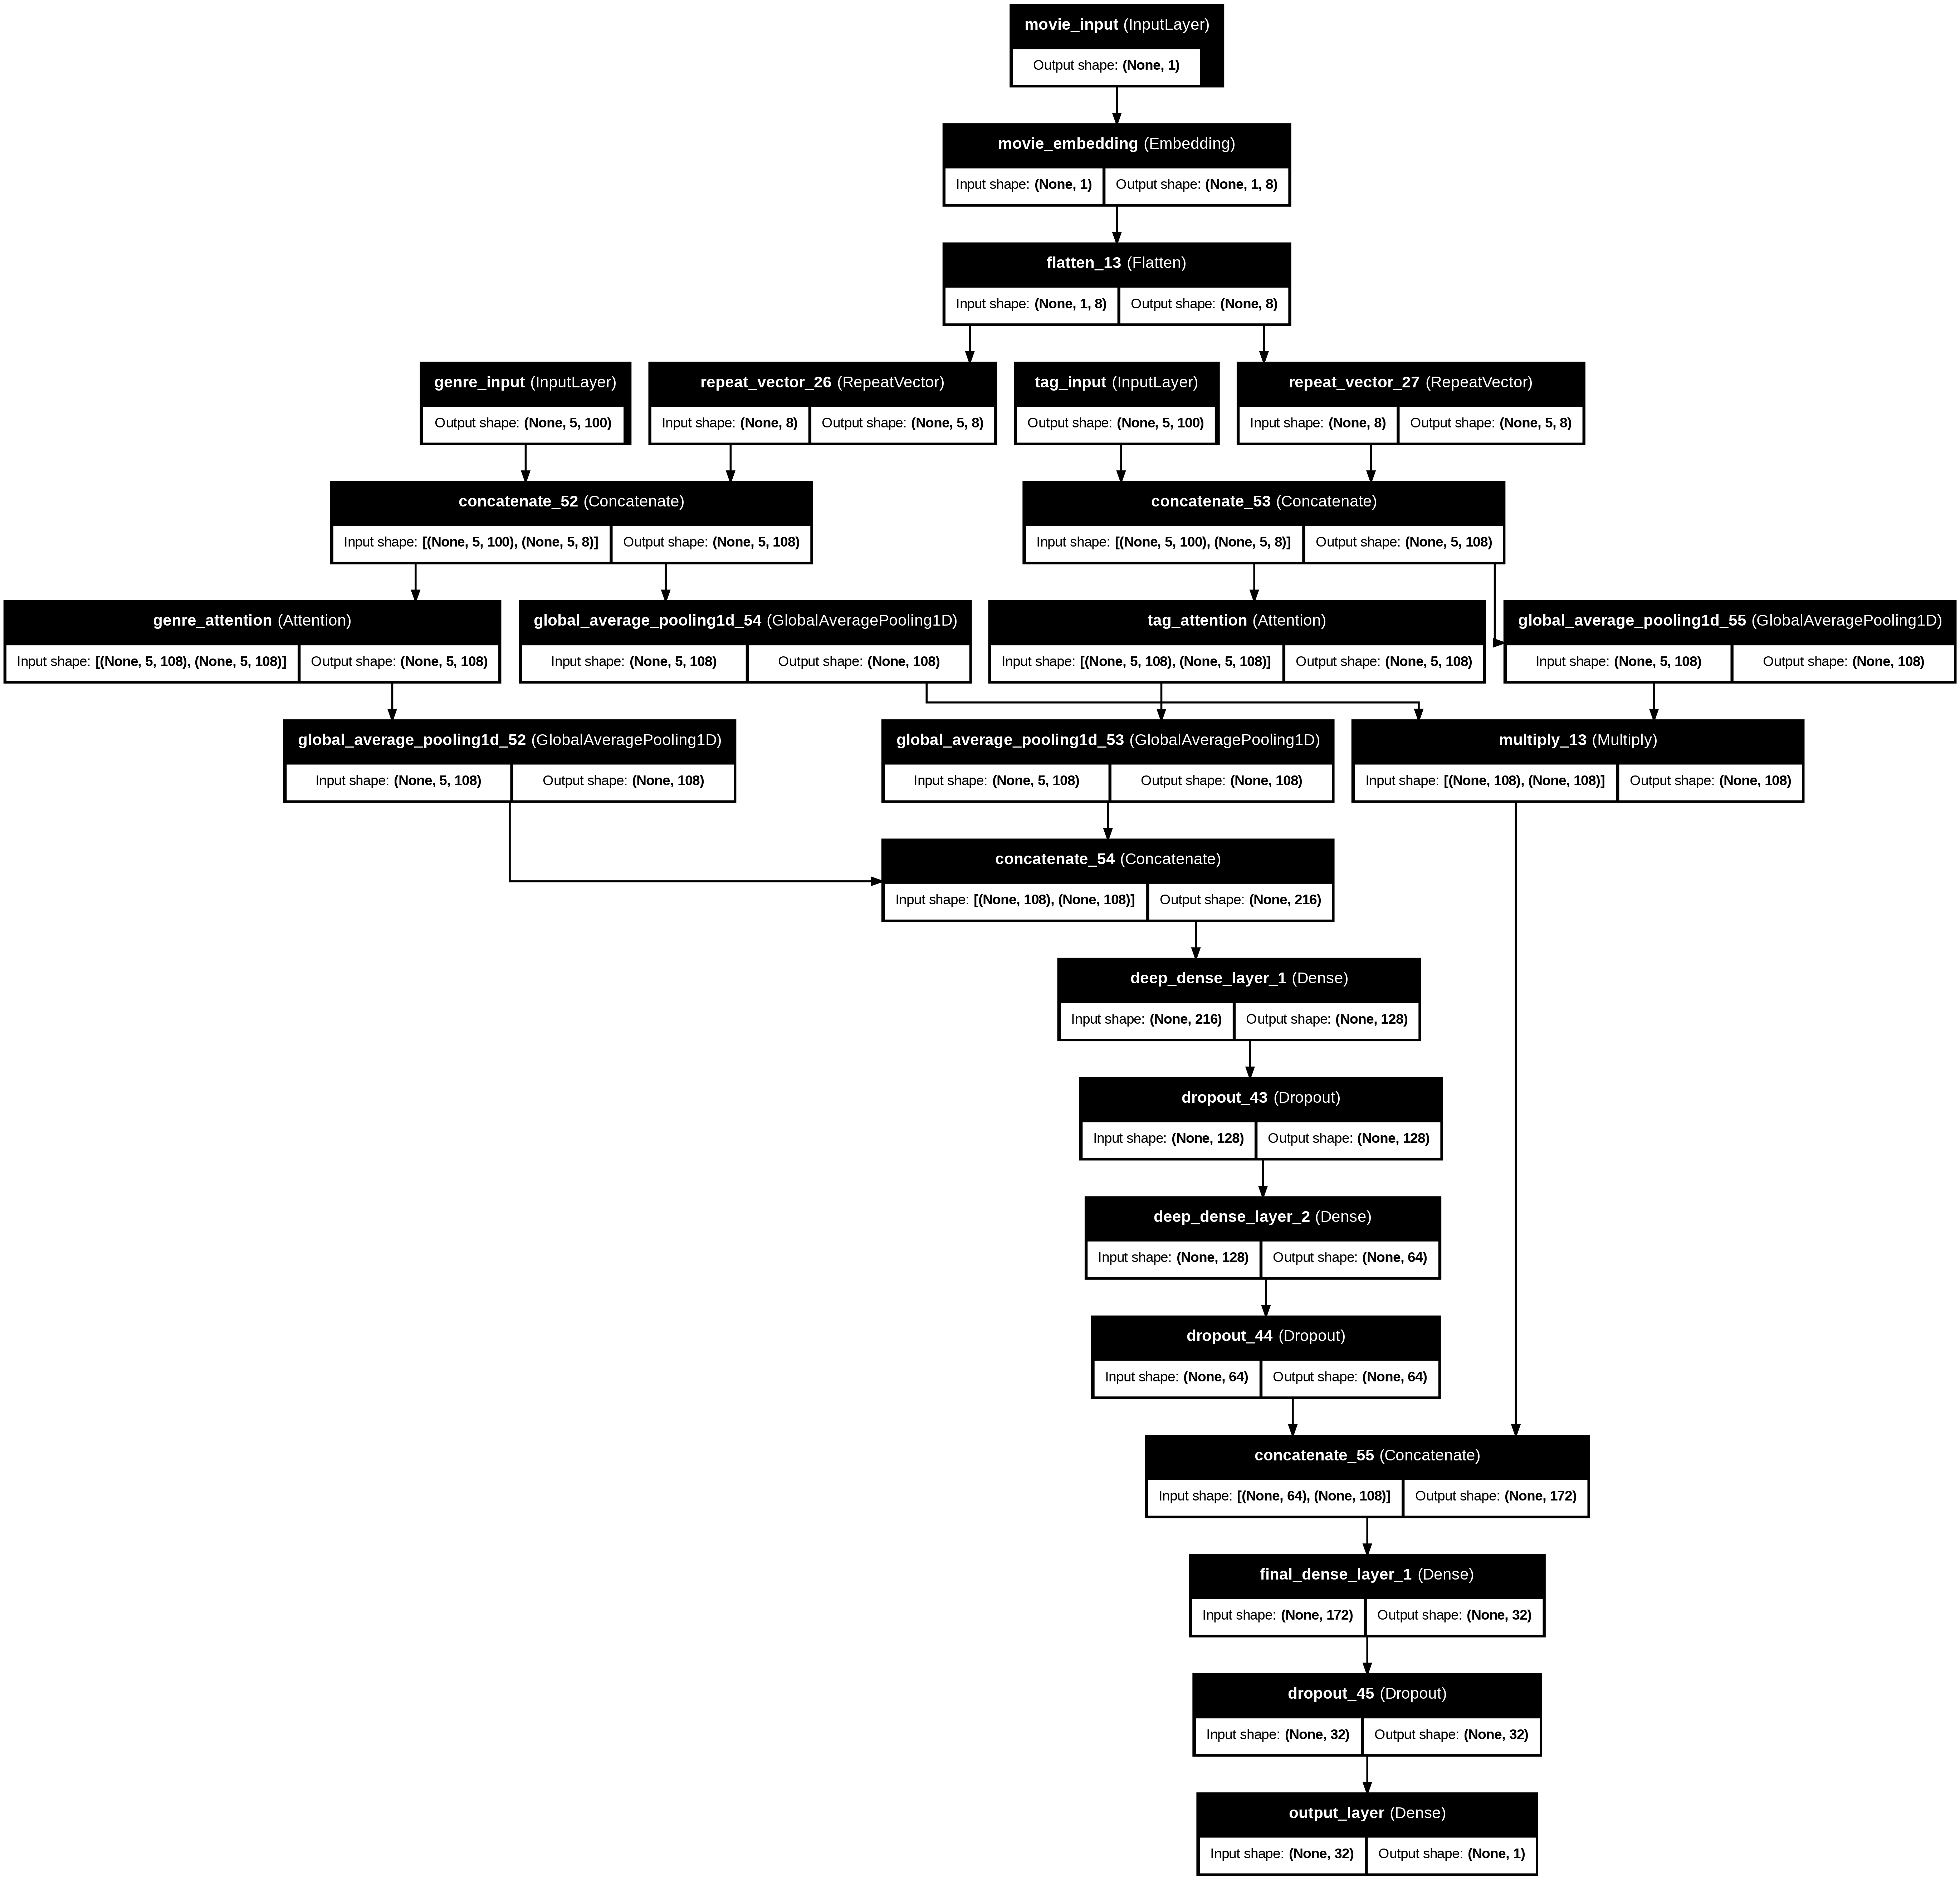

In [ ]:
# Plot model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
'''from tensorflow.keras.callbacks import ReduceLROnPlateau

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_mean_absolute_error',
    factor=0.5,
    patience=1,
    min_lr=1e-5,
    verbose=1
)'''

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

In [ ]:
EPOCHS = 30
BATCH_SIZE = 128

X_train = [X_movie_id_train, X_genres_train, X_tags_train]
X_val = [X_movie_id_val, X_genres_val, X_tags_val]

history = model.fit(
    X_train,y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30
940/940 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 7.1151 - mean_absolute_error: 1.7326 - val_loss: 2.4046 - val_mean_absolute_error: 0.8056
Epoch 2/30
940/940 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.0510 - mean_absolute_error: 0.6663 - val_loss: 1.2202 - val_mean_absolute_error: 0.3838
Epoch 3/30
940/940 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1741 - mean_absolute_error: 0.4255 - val_loss: 0.8121 - val_mean_absolute_error: 0.2986
Epoch 4/30
940/940 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8168 - mean_absolute_error: 0.3598 - val_loss: 0.5955 - val_mean_absolute_error: 0.2473
Epoch 5/30
940/940 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6035 - mean_absolute_error: 0.3143 - val_loss: 0.4564 - val_mean_absolute_error: 0.2170
Epoch 6/30
940/940 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4718 - mean_absolute_error: 0.2879 - val_loss: 0.3678 - val_mean_absolute_error: 0.2109
Epoch 7/30
940/940 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3846 - mean_absolute_error: 0.2678 - 

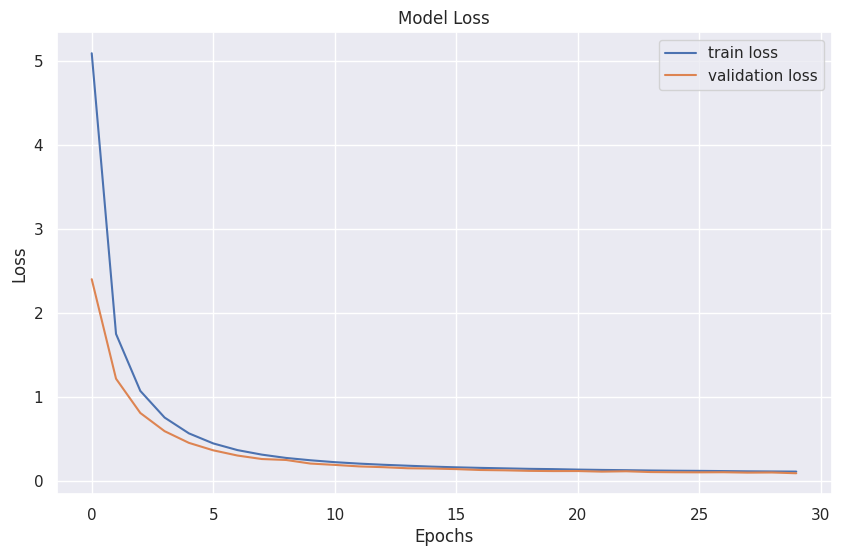

In [ ]:
# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

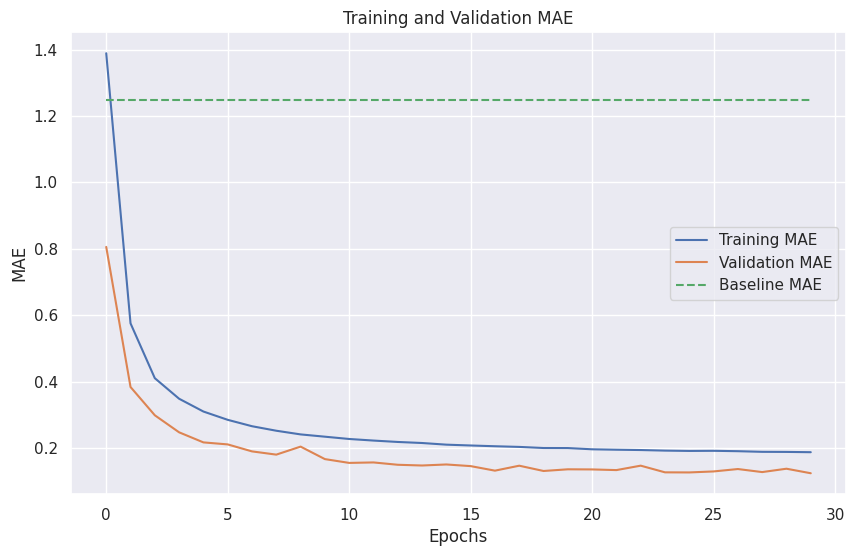

In [ ]:
# Extract MAE values
training_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
baseline_mae = mean_absolute_error(y_val, [y_val.mean()] * len(y_val))
baseline_mae_list = [baseline_mae] * len(training_mae)  # Create a list of the baseline MAE


# Plot the MAE
plt.figure(figsize=(10, 6))
plt.plot(training_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.plot(baseline_mae_list, ls='--', label='Baseline MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
# Save model
model.save('/content/drive/MyDrive/ml-32m/model.keras')

In [ ]:
'''# Evaluate the model
val_loss, val_mae = model.evaluate([X_movie_id_val, X_genres_val, X_tags_val], y_val, verbose=1)
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Mean Absolute Error: {val_mae:.4f}")
'''

'# Evaluate the model\nval_loss, val_mae = model.evaluate([X_movie_id_val, X_genres_val, X_tags_val], y_val, verbose=1)\nprint(f"Val Loss: {val_loss:.4f}")\nprint(f"Val Mean Absolute Error: {val_mae:.4f}")\n'

In [ ]:
# Predict on validation or test data
predictions = model.predict([X_movie_id_val, X_genres_val, X_tags_val])

# Reshape predictions if necessary (depending on output layer)
predictions = predictions.flatten()

# Example of displaying some predictions
range = range(5)
for i in range:
    print(f"Actual Rating: {y_val[i]:.1f}, Predicted Rating: {predictions[i]:.2f}")


940/940 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


TypeError: 'range' object is not callable

In [ ]:
y_val[0]

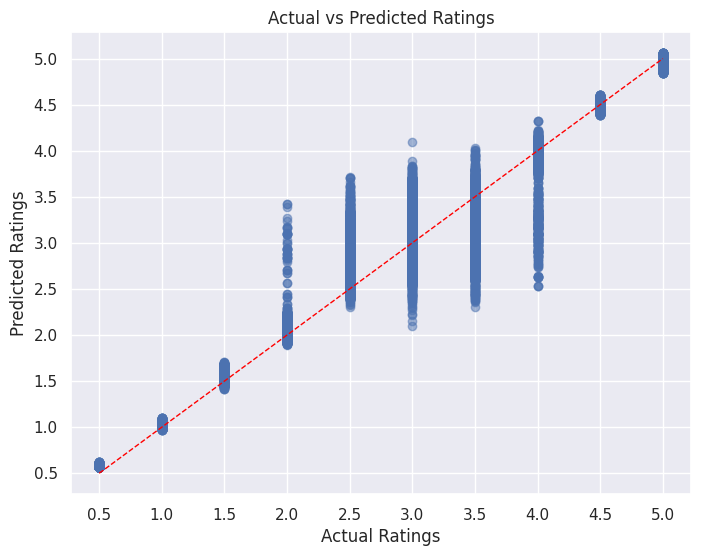

In [ ]:
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_val, predictions, alpha=0.5)
plt.plot([0.5, 5], [0.5, 5], color='red', linestyle='--', linewidth=1)  # Ideal line
ticks = np.linspace(0.5, 5.0, num=10)
plt.xticks(ticks)
plt.yticks(ticks)
plt.title("Actual vs Predicted Ratings")
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.show()

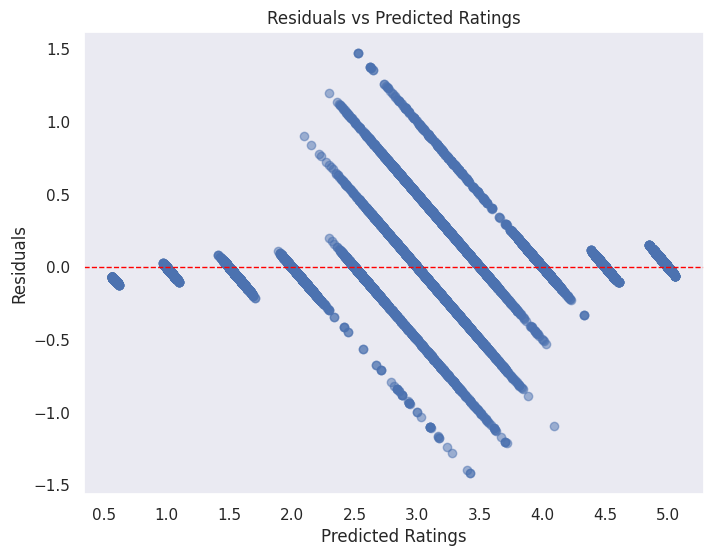

In [ ]:
residuals = y_val - predictions

plt.figure(figsize=(8, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.xticks(ticks)
plt.title("Residuals vs Predicted Ratings")
plt.xlabel("Predicted Ratings")
plt.ylabel("Residuals")
plt.grid()
plt.show()


## Feature Analysis

In [ ]:
# Load saved model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/ml-32m/model.keras')

In [ ]:
X_train = [X_movie_id_train, X_genres_train, X_tags_train]
X_val = [X_movie_id_val, X_genres_val, X_tags_val]

In [ ]:
import shap

def predict_wrapper(X):
    """
    Wrapper function to make model predictions compatible with SHAP
    X is expected to be a 2D numpy array with concatenated columns: [movie_id, flattened_genres, flattened_tags]
    """
    # Ensure X is properly sliced
    num_movies = 1
    num_genres = 5 * 100  # Flattened genres
    num_tags = 5 * 100    # Flattened tags

    movie_ids = X[:, :num_movies]  # Movie IDs
    genres = X[:, num_movies:num_movies + num_genres].reshape(-1, 5, 100)  # Reshape to (5, 100)
    tags = X[:, num_movies + num_genres:].reshape(-1, 5, 100)  # Reshape to (5, 100)

    # Return predictions
    return model.predict([movie_ids, genres, tags]).flatten()



# Flatten the genre and tag embeddings for concatenation
X_genres_val_flattened = X_genres_val.reshape(X_genres_val.shape[0], -1)  # (num_samples, 5 * 100)
X_tags_val_flattened = X_tags_val.reshape(X_tags_val.shape[0], -1)        # (num_samples, 5 * 100)

# Combine validation data into a single 2D array
X_combined = np.hstack([X_movie_id_val.reshape(-1, 1), X_genres_val_flattened, X_tags_val_flattened])

# Define SHAP explainer with the updated combined data
explainer = shap.KernelExplainer(predict_wrapper, X_combined[:50])

# Calculate SHAP values for a sample of validation data
shap_values = explainer.shap_values(X_combined[:200])


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━

In [ ]:
shap_values.shape

(200, 1001)

In [ ]:
X_movie_id_val.flatten().shape

(30070,)

In [ ]:
# Prepare the list of unique genres and tags from the validation set
movie_ids_val = X_movie_id_val.flatten()
final_df_val = final_df[final_df['movieId'].isin(movie_ids_val)]

# Check the number of validation samples and SHAP values
num_samples = shap_values.shape[0]
num_features = shap_values.shape[1]

# Ensure that final_df_val has more than 100 rows
final_df_val = final_df_val.iloc[:num_samples]

# Adjust indices based on where your genre and tag features start
genre_shap = shap_values[:, 1:1001]  # Assuming columns 1 to 1000 correspond to genre and tag features

# Create mappings for genres and tags based on unique features
unique_genres = list(set([genre for genres in final_df_val['genres'].apply(clean_and_split) for genre in genres]))
unique_tags = list(set([tag for tags in final_df_val['top_tags'].apply(clean_and_split) for tag in tags]))

# Map SHAP values to genres and tags
genre_shap_mapping = {genre: {'impact': [], 'direction': []} for genre in unique_genres}
tag_shap_mapping = {tag: {'impact': [], 'direction': []} for tag in unique_tags}

# Initialize mapping for genres and tags with empty lists
genre_shap_mapping = {genre: [] for genre in unique_genres}
tag_shap_mapping = {tag: [] for tag in unique_tags}

# Loop through the validation data to map SHAP values to genres and tags
for i, row in final_df_val.iterrows():
    if i >= num_samples:
        break  # Stop if we exceed the available SHAP values

    # Extract genres and tags for the current validation instance
    movie_genres = clean_and_split(row['genres'])
    movie_tags = clean_and_split(row['top_tags'])

    # Add SHAP values for genres
    for genre in movie_genres:
        if genre in genre_shap_mapping:
            # Append all SHAP values directly without averaging
            genre_shap_mapping[genre].append(genre_shap[i].tolist())  # Append the list of SHAP values for this instance

    # Add SHAP values for tags
    for tag in movie_tags:
        if tag in tag_shap_mapping:
            # Append all SHAP values directly without averaging
            tag_shap_mapping[tag].append(genre_shap[i].tolist())  # Append the list of SHAP values for this instance

# Flatten the lists for each genre and tag
genre_shap_mapping = {genre: [val for sublist in values for val in sublist] for genre, values in genre_shap_mapping.items()}
tag_shap_mapping = {tag: [val for sublist in values for val in sublist] for tag, values in tag_shap_mapping.items()}

# Calculate mean importance and count
genre_importance = {}
for genre, values in genre_shap_mapping.items():
    if values:
        genre_importance[genre] = {
            'impact': np.mean(values),
            'count': len([x for x in final_df_val['genres'].apply(clean_and_split) if genre in x])
        }

tag_importance = {}
for tag, values in tag_shap_mapping.items():
    if values:
        tag_importance[tag] = {
            'impact': np.mean(values),
            'count': len([x for x in final_df_val['top_tags'].apply(clean_and_split) if tag in x])
        }

# Convert to DataFrames
genre_df = pd.DataFrame.from_dict(genre_importance, orient='index')
genre_df['genre'] = genre_df.index
genre_df = genre_df.reset_index(drop=True)
genre_df = genre_df.sort_values('impact', ascending=False)

tag_df = pd.DataFrame.from_dict(tag_importance, orient='index')
tag_df['tag'] = tag_df.index
tag_df = tag_df.reset_index(drop=True)
tag_df = tag_df.sort_values('impact', ascending=False)

# Print results
print("Top genres by SHAP impact:")
print(genre_df)
print("\nTop tags by SHAP impact:")
print(tag_df)

Top genres by SHAP impact:
      impact  count        genre
9   0.000119      3      Western
5   0.000114     33     Thriller
0   0.000114      7      Fantasy
10  0.000088     73       Comedy
4   0.000076     11       Horror
14  0.000054     16    Adventure
7   0.000042     42      Romance
13  0.000036    109        Drama
1   0.000032     13     Children
2   0.000012     12       Sci-Fi
8   0.000004     19        Crime
6  -0.000039      7      Mystery
11 -0.000042     31       Action
3  -0.000108      6  Documentary
12 -0.000160      6          War

Top tags by SHAP impact:
       impact  count                 tag
116  0.000580      1          court case
134  0.000580      1           courtroom
43   0.000580      2           blackmail
122  0.000580      1              jurors
58   0.000365      1           ClearPlay
..        ...    ...                 ...
139 -0.000230      2           Biography
127 -0.000230      1         Glenn Close
17  -0.000317      3            new york
19  -0.00

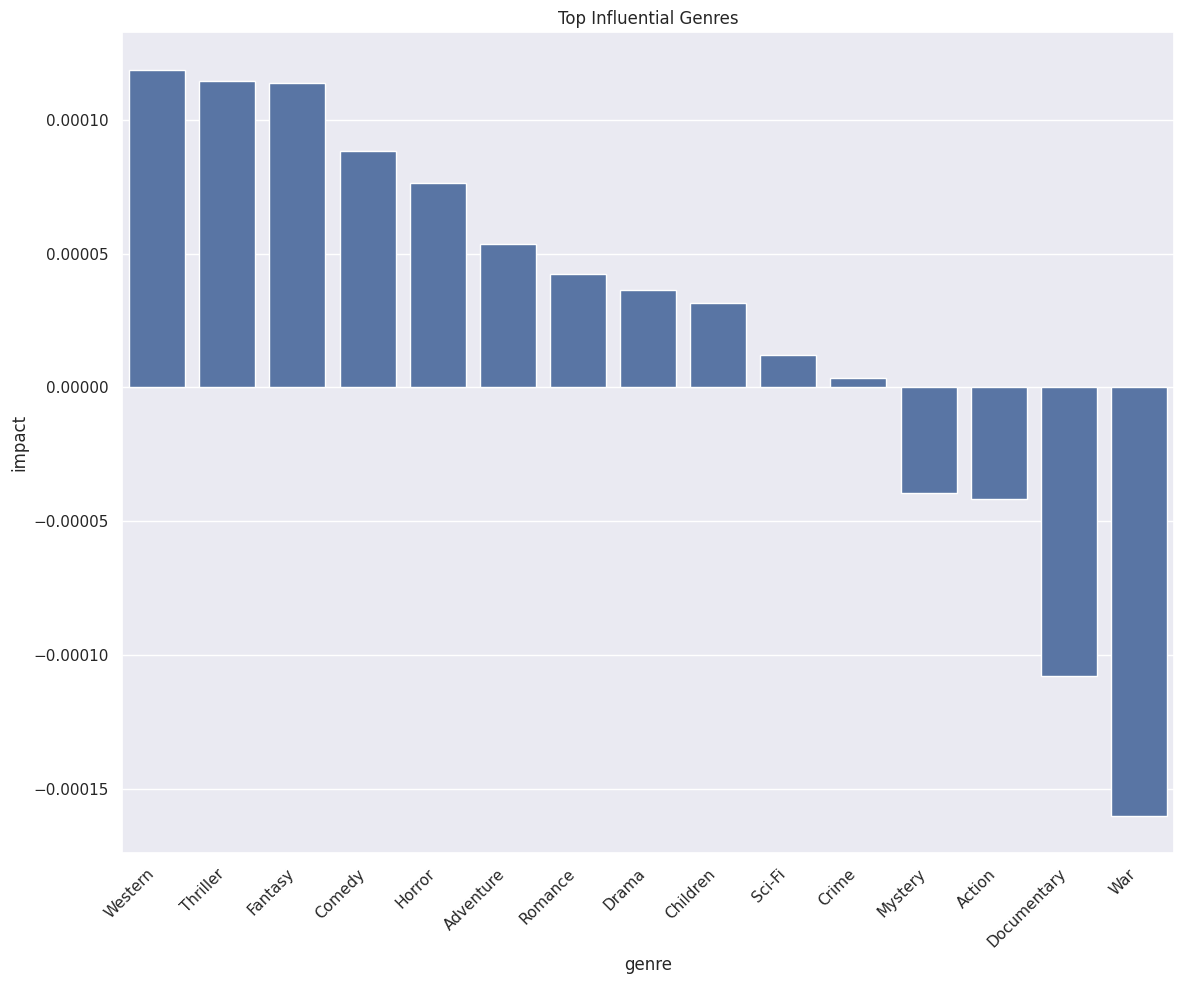

In [ ]:
# Genres
plt.figure(figsize=(12, 10))
sns.barplot(x='genre', y='impact', data=genre_df)
plt.title('Top Influential Genres')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

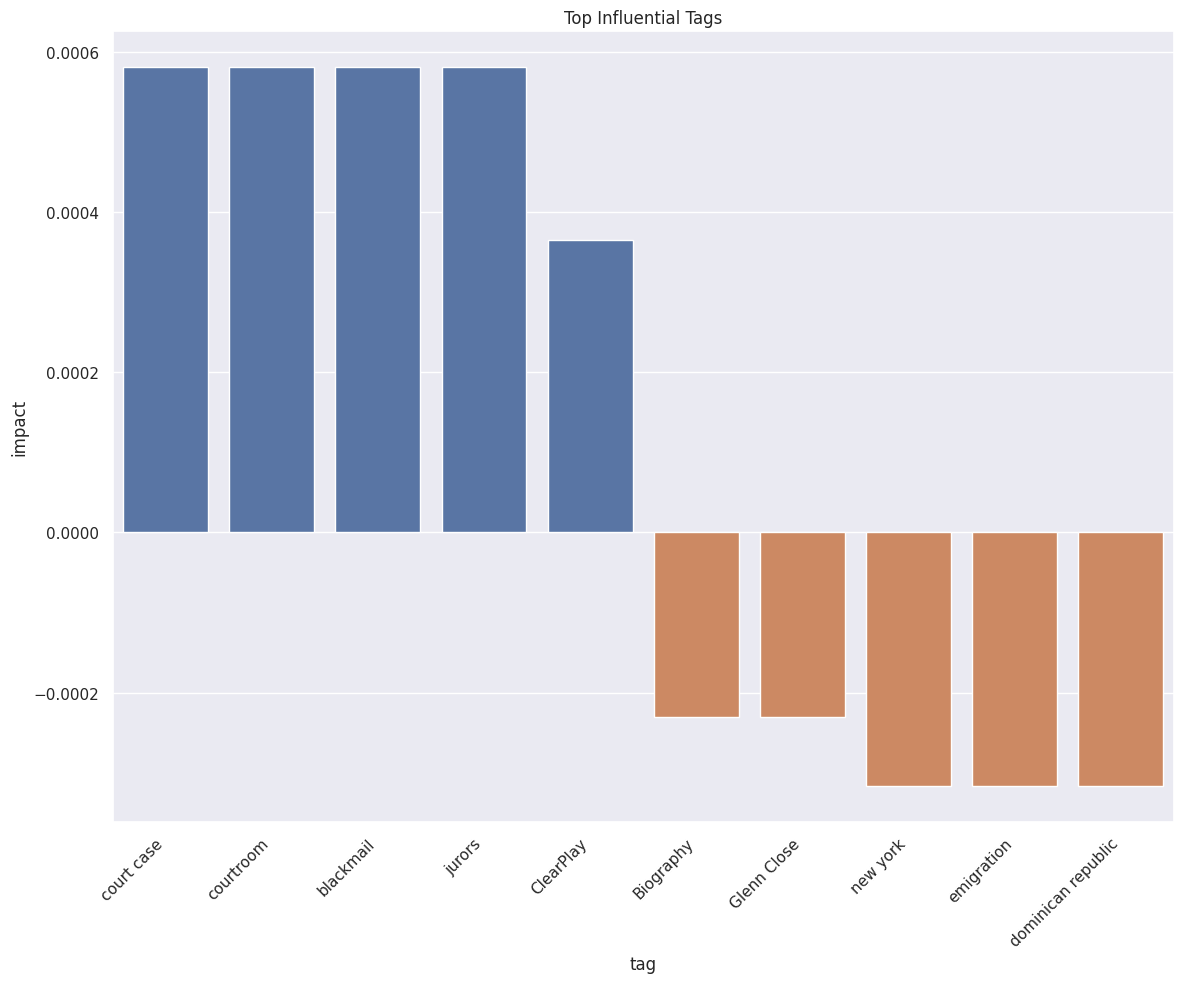

In [ ]:
# Tags
plt.figure(figsize=(12, 10))
sns.barplot(x='tag', y='impact', data=tag_df.head(5))
sns.barplot(x='tag', y='impact', data=tag_df.tail(5))
plt.title('Top Influential Tags')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
